# Synthetic Glacier: Geometry Generation 

Lets extract some data along an extended flowline for our Synthetic Glacier. Information we will extract:  
  * Surface profile from SRTM DEM,  
  * Bedrock profile from Faranotti et al. 2019

In [4]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import scipy.signal as signal
from scipy import linalg as LA
import matplotlib.pyplot as plt

# Set global matplotlib style parameters
plt.rcParams.update({'font.size': 14, 
                     'text.usetex': True, 
                     'figure.facecolor': 'w'})

# define some usefull functions 
def centerline_2_points(geom, dx=30):
    """convert shapeline to shapepoints spaced at specified interval"""
    # https://stackoverflow.com/a/35025274/10221482
    num_vert = int(round(geom.length / dx))
    if num_vert == 0: 
        num_vert = 1
    multipoint = [geom.interpolate(float(n)/num_vert,normalized=True) for n in range(num_vert + 1)] 
    Latx = [multipoint[i].x for i in range(len(multipoint))]
    Laty = [multipoint[i].y for i in range(len(multipoint))]
    gdf  = gpd.GeoDataFrame(geometry=gpd.points_from_xy(Latx,Laty))
    return gdf

def lstq(x,y,order):
    """Wrapper for least-squares fitting"""
    A     = np.vstack([x**i for i in range(0,order)]).T
    coefs = LA.lstsq(A,y)[0]
    return coefs

File-path to source rasters. 

In [5]:
EB_2007_fp = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/EB/dem_2007.tif'
BED_DEM_fp = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/Faranotti_2020/RGI60-01.16198_BDEM.tif'
SRTM_fp    = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/SRTM/AST_merge/ASTGTMV003_MERGED_UTM7N.tif'
GC_Surf_fp = '/Users/andrewnolan/sfuvault/LilKluane/DEMS/Faranotti_2020/surface_DEM_RGI60-01.16198.tif'

Let's read in the flowline, and convert from a shapeline to shape points. 

In [6]:
FL_dir = '/Users/andrewnolan/sfuvault/LilKluane/flowlines/'

# What tributary are we looking at?
SURGE_TRIB = True

if SURGE_TRIB:
    #FL_fp = os.path.join(FL_dir,'alexis/centerlines_postsurge_UTM7N.shp')
    FL_fp = os.path.join(FL_dir,'alexis/centerlines_postsurge_UTM7N_extended.shp')
    # Read the centerline for Little Kluane
    LK_FL = gpd.read_file(FL_fp)
    LK_CP = centerline_2_points(LK_FL[LK_FL['MAIN'] == 1], dx=10)
    # For whatever reason we need to flip the oggm flowline
    LK_CP = LK_CP.sort_index(axis=0,ascending=False).reset_index(drop=True)
else:
    FL_fp = os.path.join(FL_dir,'manual/main/Little_Kluan_FL_main.shp')
    # Read the centerline for Little Kluane
    LK_FL = gpd.read_file(FL_fp)
    LK_CP = centerline_2_points(LK_FL, dx=10)

LK_CP['UTM_N'] = None
LK_CP['UTM_E'] = None

for i,row in enumerate(LK_CP['geometry']):
    LK_CP.iloc[i,1] = row.y
    LK_CP.iloc[i,2] = row.x   
    
prof_coords = [(x,y) for x, y in zip(LK_CP.UTM_E, LK_CP.UTM_N)]

Now, let's extract raster values at the shape point locations. 

In [7]:
with rasterio.open(EB_2007_fp) as src:
    LK_CP['EB_2007'] = [x for x in src.sample(prof_coords)]
    LK_CP['EB_2007'] = LK_CP.apply(lambda x: x['EB_2007'][0], axis=1)

with rasterio.open(SRTM_fp) as src:
    LK_CP['SRTM'] = [x for x in src.sample(prof_coords)]
    LK_CP['SRTM'] = LK_CP.apply(lambda x: x['SRTM'][0], axis=1)

with rasterio.open(GC_Surf_fp) as src:
    LK_CP['GC_Surf'] = [x for x in src.sample(prof_coords)]
    LK_CP['GC_Surf'] = LK_CP.apply(lambda x: x['GC_Surf'][0], axis=1)
    
with rasterio.open(BED_DEM_fp) as src:
    bed_nodata = src.nodata
    LK_CP['bedprof'] = [x for x in src.sample(prof_coords)]
    LK_CP['bedprof'] = LK_CP.apply(lambda x: x['bedprof'][0], axis=1)

# Replace nodata with np.nan
LK_CP = LK_CP.replace([-9999.0, 0.0, bed_nodata],np.nan)

# x-coordinate in km 
x_dx10 = LK_CP.index.to_numpy() * 10.0 / 1000.0

Let's look a the raw data: 

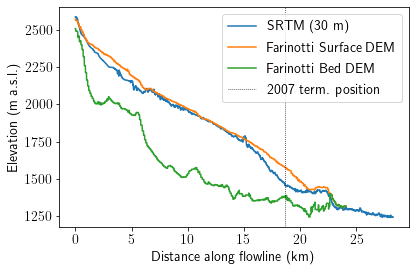

In [12]:
fig, ax = plt.subplots()

# ax.plot(x_dx10, LK_CP['EB_2007'], label='EB 2007 DEM')
ax.plot(x_dx10[::-1], LK_CP['SRTM']   , label='SRTM (30 m)')
ax.plot(x_dx10[::-1], LK_CP['GC_Surf'], label='Farinotti Surface DEM')
ax.plot(x_dx10[::-1], LK_CP['bedprof'], label='Farinotti Bed DEM')

ax.set_ylabel('Elevation (m a.s.l.)')
ax.set_xlabel('Distance along flowline (km)')


ax.axvline(x_dx10.max()-9.6, label='2007 term. position',c='k', ls=':', lw=0.75)
ax.legend()

plt.tight_layout()

The F2019 ice-thickness model has systematic errors at the study location due, at least in part, to outdated glacier outlines. 
We attempt to manually correct these errors to create an accurate and stable synthetic reference geometry. 
Farinotti _etal_ 2019 use the GLIMS/RGI outline, which, in this case, includes the glacier of interest (dubbed "Little Kluane" in air photographs by Austin Post) as a tributary connected to the Kluane Glacier (RGI Glacier ID: RGI60-01.16198). 
This tributary, however, has retreated $\sim$3 km from its former confluence with the Kluane Glacier, meaning ice thickness is non-zero in the F2019 dataset over several kilometres of currently ice-free terrain. 

Let's zoom into this area of systematic error for a bit more detail. 

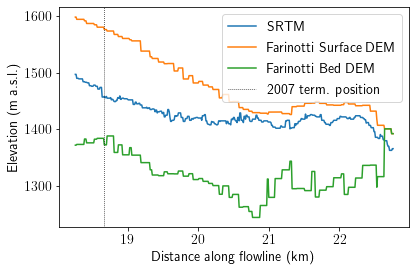

In [13]:
fig, ax = plt.subplots()

# ax.plot(x_dx10[550:1001], LK_CP['EB_2007'][550:1001], label='EB 2007 DEM')
ax.plot(x_dx10[::-1][550:1001], LK_CP['SRTM'][550:1001]   , label='SRTM')
ax.plot(x_dx10[::-1][550:1001], LK_CP['GC_Surf'][550:1001], label='Farinotti Surface DEM')
ax.plot(x_dx10[::-1][550:1001], LK_CP['bedprof'][550:1001], label='Farinotti Bed DEM')

ax.set_ylabel('Elevation (m a.s.l.)')
ax.set_xlabel('Distance along flowline (km)')


ax.axvline(x_dx10.max()-9.6, label='2007 term. position',c='k', ls=':', lw=0.75)
ax.legend()

plt.tight_layout()

Let's smooth the surface and bed profiles with a [Savgol Filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html). 

In [19]:
ss_poly   = np.polyval( np.polyfit(x_dx10, LK_CP['SRTM'], 10), x_dx10)
ss_smooth = signal.savgol_filter( x=LK_CP['SRTM'],   window_length=211, polyorder=5)
bb_smooth = signal.savgol_filter( x=LK_CP['bedprof'],window_length=211, polyorder=5)

correction = np.mean(ss_smooth[550:1001] - bb_smooth[550:1001])

print('Avg. Diff. over are of systematic error: {:.0f} m'.format(correction))

Avg. Diff. over are of systematic error: 104 m


We make a crude correction to the reference glacier geometry by increasing the F2019 bed elevation everywhere by 104 m . 

In [20]:
ss_prop = np.concatenate([ss_smooth[x_dx10 <= 9.0], ss_poly[x_dx10 > 9.0]])
bb_prop = np.concatenate([ss_smooth[x_dx10 <= 9.0], (bb_smooth + correction)[x_dx10 > 9.0]])

Finally, let's visualize the raw, intermediate, and final beds: 

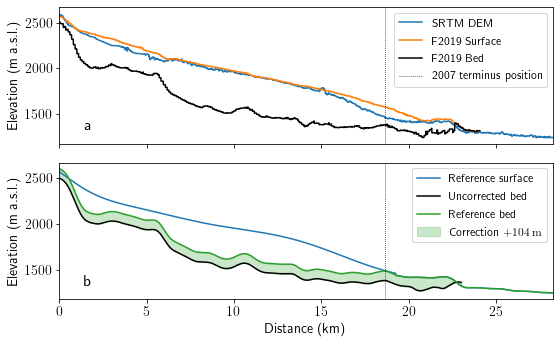

In [21]:
fig, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(8,5))

# ax[0].plot(x_dx10, LK_CP['EB_2007'], label='EB 2007 DEM')
ax[0].plot(x_dx10[::-1], LK_CP['SRTM']   , label='SRTM DEM')
ax[0].plot(x_dx10[::-1], LK_CP['GC_Surf'], label='F2019 Surface')
ax[0].plot(x_dx10[::-1], LK_CP['bedprof'], label='F2019 Bed', c='k')

ax[0].set_ylabel('Elevation (m a.s.l.)')

ax[0].axvline(x_dx10[-1] - 9.6, label='2007 terminus position',c='k', ls=':', lw=0.75)
ax[0].legend(fontsize='small')
ax[0].text(0.05, 0.1, 'a', transform=ax[0].transAxes, 
               fontsize=16, fontweight='bold')

ax[1].plot(x_dx10[::-1], ss_prop,  label='Reference surface')
ax[1].plot(x_dx10[::-1], bb_smooth,label='Uncorrected bed', c='k')
ax[1].plot(x_dx10[::-1], bb_prop,  label='Reference bed', c='tab:green')
ax[1].fill_between(x_dx10[::-1], 
                 bb_smooth, bb_prop, 
                 color='tab:green', alpha=0.25, 
                 label=r'Correction $+104 \; \rm{m}$')

# np.concatenate([ss_smooth[x_coord < 9.0], (bb + correction)[x_coord >= 9.0]])
ax[1].set_ylabel('Elevation (m a.s.l.)')
ax[1].set_xlabel('Distance (km)')

ax[1].axvline(x_dx10[-1] - 9.6,  c='k', ls=':', lw=0.75)
# ax[1].axvline(x_dx10[-1] - 27.7, label='New maximum extent',  c='r', ls='--', lw=0.75)

ax[1].set_xlim(x_dx10[0], x_dx10[-1])
ax[1].legend(fontsize='small')
ax[1].text(0.05, 0.1, 'b', transform=ax[1].transAxes, 
               fontsize=16, fontweight='bold')
plt.tight_layout()

fig.savefig('../plots/GeometryGeneration.pdf',bbox_inches='tight')

We truncate the uppermost portion of the flowline by $\sim$ 1 km, where bed elevation exceeds surface elevation after applying the correction. Hereafter, we refer to the smoothed and corrected profiles as the  "reference" profiles. 

Let's now write reference profiles to a file. 

In [12]:
xx  = np.linspace(x_dx10.min()*1e3,x_dx10.max()*1e3,x_dx10.shape[0])

# Chop off the upper portion where ice-thickness would be zero
ss_new = ss_prop[:2770]
bb_new = bb_prop[:2770]
xx_new = xx[:2770]


np.savetxt('../Data/Topography/REF_BedTopo.dat'   , np.array([xx_new,bb_new]).T,fmt='%.3e')
np.savetxt('../Data/Topography/REF_SurfTopo.dat'  , np.array([xx_new,ss_new]).T,fmt='%.3e')